# GMDL HW2 - PCA and Autoencoders
In this assignment you will implement two dimensionality reduction schemes
we saw in class:
1. Principal Component Analysis (PCA)
2. Autoencoder

You will also implement an image denoising model to enhance the performance of a simple MLP classifier.

The data used in the following exercises is a subset of the MNIST dataset.
Randomly sample 10,000 images from MNIST train set (you may set a random.seed).



In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm

# EX1. PCA dimensionality reduction (20pts)

1. Implement the PCA procedure in the function ```perform_PCA()```.

Useful functions:
```
sklearn.preprocessing.StandardScaler
scipy.linalg.eigh
numpy.matmul
```
The input should be in vector form (i.e., flatten the input images beforehand).

2. Project the data to 2D, i.e, $\mathbb{R}^{784}↦ \mathbb{R}^2$.
3. Scatter plot the data using the 2D projection and class labels. You'll need to implement ```plot_projected_data()```


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh

def perform_PCA(X, n_components):
    """
    Implement the PCA algorithm.
    Input: X [numpy array] - shape: (N,784)
           n_components [int] - number of principal components to retain
    Output: Projected data using n_components
    """
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Compute the covariance matrix
    cov_matrix = np.cov(X_scaled, rowvar=False)

    # Compute eigenvalues and eigenvectors of the covariance matrix
    eigvals, eigvecs = eigh(cov_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]

    # Select the top n_components eigenvectors
    principal_components = eigvecs[:, :n_components]

    # Project the data onto the principal components
    projected_data = np.matmul(X_scaled, principal_components)

    return projected_data

def plot_projected_data(X, y):
    """
    Plot 2D projection of data after PCA.
    Input: X [numpy array] - shape: (N,2)
           y [numpy array] - labels for each data point
    Output: None (plots the data)
    """
    plt.figure(figsize=(8, 6))
    classes = np.unique(y)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange', 'gray']
    for class_idx, class_label in enumerate(classes):
        plt.scatter(X[y == class_label, 0], X[y == class_label, 1],
                    color=colors[class_idx % len(colors)], label=str(class_label))
    plt.title('2D Projection of Data after PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='best')
    plt.show()

In [17]:
# Please use the (0.5, 0.5) normalization value, as
# they were used for training the MLP in EX5
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST train and test datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


# Sample 10K images
train_indices = np.random.choice(len(trainset), 10000, replace=False)
train_subset = Subset(trainset, train_indices)

trainloader = DataLoader(train_subset , batch_size=256, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)
# Function to flatten the images
def flatten_images(images):
    return images.view(images.size(0), -1).numpy()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


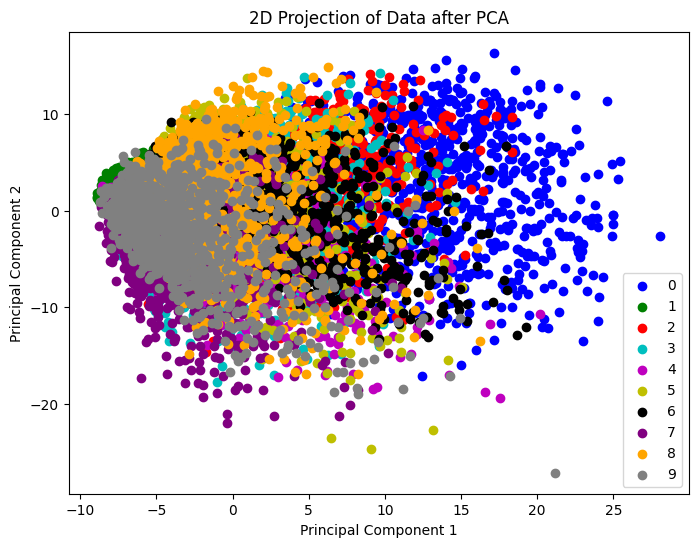

In [18]:

# Flatten and preprocess the train subset for PCA
X_train_flattened = flatten_images(torch.cat([trainset[i][0] for i in train_indices], dim=0))

# Perform PCA to reduce to 2 dimensions
X_train_projected = perform_PCA(X_train_flattened, n_components=2)

# Plot the projected data
plot_projected_data(X_train_projected, np.array([trainset[i][1] for i in train_indices]))

# EX2 Autoencoder (AE) (20pts)
1. Implement a fully-connected Autoencoder. The encoder and decoder should have 2 layers each. Use ReLU activation function.
2. The so-called 'code' should be two-dimensional. In other words, the output of the encoder should be 2.
3. Plot the training loss.

4. Project the data using your AE. Plot the data using ```plot_projected_data()```

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

# Define the Autoencoder class
class MLP_AE(nn.Module):
    def __init__(self):
        super(MLP_AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),  # Increased units
            nn.ReLU(),
            nn.Linear(512, 256),  # Existing layers
            nn.ReLU(),
            nn.Linear(256, 2)
          )
        self.decoder = nn.Sequential(
            nn.Linear(2, 256),  # Existing layers
            nn.ReLU(),
            nn.Linear(256, 512),  # Increased units
            nn.ReLU(),
            nn.Linear(512, 784)
          )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Autoencoder model
model = MLP_AE()
print(model)  # Print model summary to verify architecture

MLP_AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [6]:
# Set the normalization values
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST train and test datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Sample 10K images from the train set
train_indices = np.random.choice(len(trainset), 10000, replace=False)
train_subset = Subset(trainset, train_indices)

# DataLoader for train and test sets
trainloader = DataLoader(train_subset, batch_size=256, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)

# Function to flatten the images
def flatten_images(images):
    return images.view(images.size(0), -1)

Epoch [1/20], Loss: 0.5926
Epoch [2/20], Loss: 0.2717
Epoch [3/20], Loss: 0.2652
Epoch [4/20], Loss: 0.2620
Epoch [5/20], Loss: 0.2504
Epoch [6/20], Loss: 0.2453
Epoch [7/20], Loss: 0.2420
Epoch [8/20], Loss: 0.2373
Epoch [9/20], Loss: 0.2329
Epoch [10/20], Loss: 0.2312
Epoch [11/20], Loss: 0.2297
Epoch [12/20], Loss: 0.2284
Epoch [13/20], Loss: 0.2269
Epoch [14/20], Loss: 0.2248
Epoch [15/20], Loss: 0.2227
Epoch [16/20], Loss: 0.2187
Epoch [17/20], Loss: 0.2159
Epoch [18/20], Loss: 0.2127
Epoch [19/20], Loss: 0.2100
Epoch [20/20], Loss: 0.2084


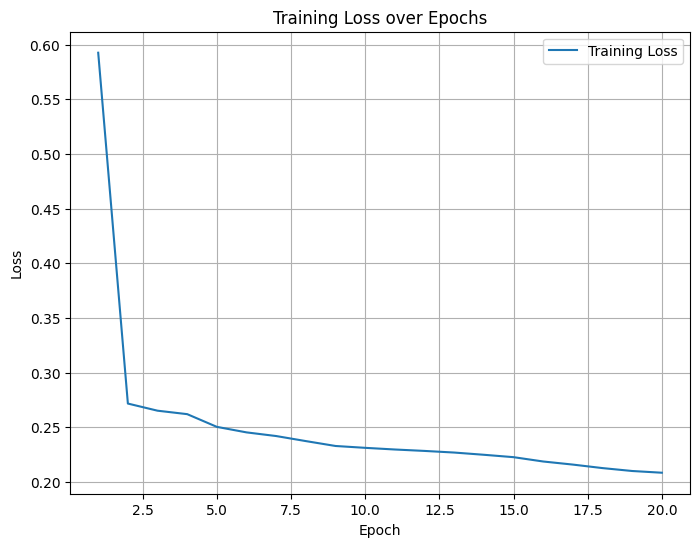

In [7]:
# Initialize the Autoencoder model
model = MLP_AE()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training the Autoencoder
num_epochs = 20
encoded_data_nonlinear  = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in trainloader:
        # Flatten images and convert to float tensor
        images = images.view(images.size(0), -1)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, images)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average loss for epoch
    epoch_loss = running_loss / len(trainloader)
    encoded_data_nonlinear .append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Plotting the training loss
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), encoded_data_nonlinear , label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

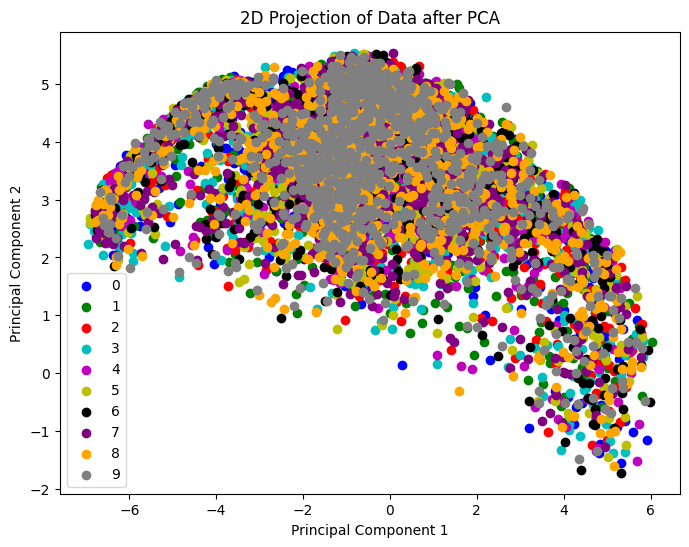

In [8]:
encoded_data_nonlinear = []
with torch.no_grad():
    for images, labels in trainloader:
        images = flatten_images(images)
        encoded_output = model.encoder(images)
        encoded_data_nonlinear.append(encoded_output.numpy())

encoded_data_nonlinear = np.concatenate(encoded_data_nonlinear, axis=0)
# Plot the projected data
plot_projected_data(encoded_data_nonlinear, np.array([trainset[i][1] for i in train_indices]))

Original Images


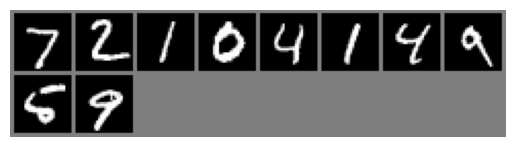

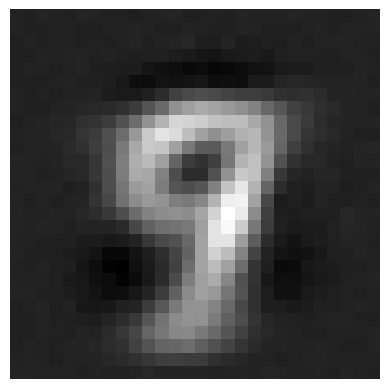

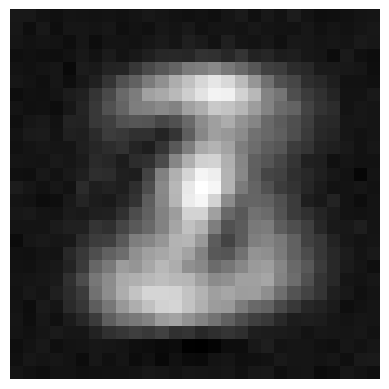

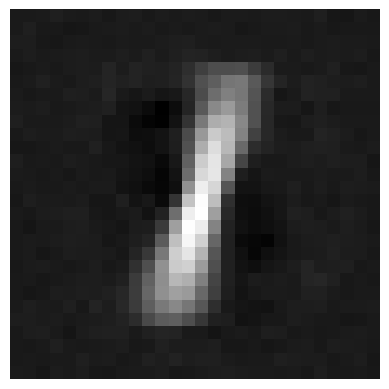

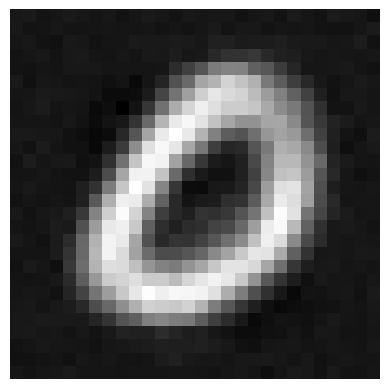

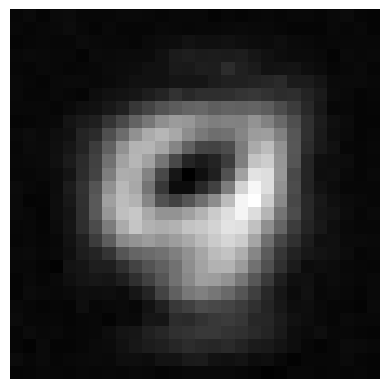

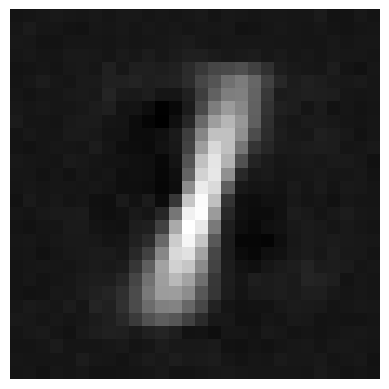

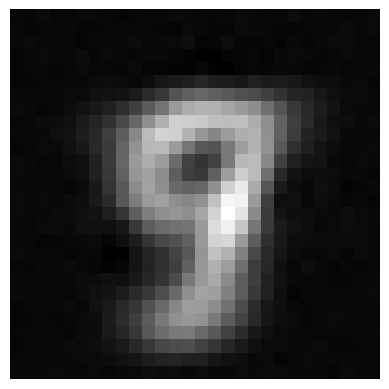

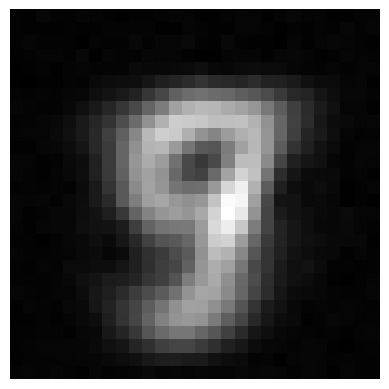

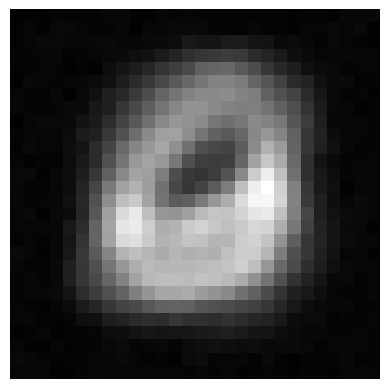

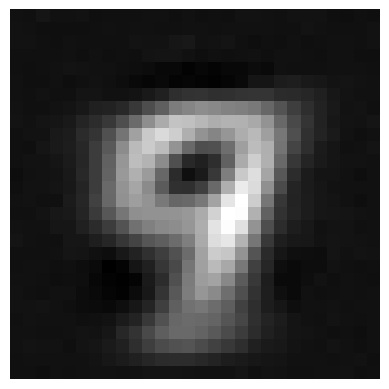

In [9]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Compare original and reconstructed images
model.eval()
dataiter = iter(testloader)
images, labels = next(dataiter)

# Original images
print('Original Images')
imshow(torchvision.utils.make_grid(images[:10]))

# Reconstructed images
with torch.no_grad():
    images = flatten_images(images[:10])
    outputs = model(images)
    outputs = outputs.view(-1, 1, 28, 28).cpu().numpy()  # Convert to numpy array

    for i in range(10):
        # Rescale the pixel values to [0, 1] for display
        reconstructed_img = outputs[i][0] / 255.0

        # Display reconstructed image
        plt.figure()
        plt.imshow(reconstructed_img, cmap='gray')
        plt.axis('off')
        plt.show()

# EX3 Linear Autoencoder (20pts)
1. Follow the steps of EX2, but remove the nonlinear activation functions.

4. Project the data using your AE. Plot the data using ```plot_projected_data()```

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

# Define the Linear Autoencoder class
class LinearAE(nn.Module):
    def __init__(self):
        super(LinearAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),  # Input size 784 (flattened MNIST image)
            nn.Linear(256, 2)  # Output size 2 (encoded representation)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 256),  # Input size 2 (encoded representation)
            nn.Linear(256, 784)  # Output size 784 (reconstructed image)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the Linear Autoencoder model
model = LinearAE()
print(model)  # Print model summary to verify architecture

LinearAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=784, bias=True)
  )
)


In [11]:
# Set the normalization values
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST train and test datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Sample 10K images from the train set
train_indices = np.random.choice(len(trainset), 10000, replace=False)
train_subset = Subset(trainset, train_indices)

# DataLoader for train and test sets
trainloader = DataLoader(train_subset, batch_size=256, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)

# Function to flatten the images
def flatten_images(images):
    return images.view(images.size(0), -1)

Epoch [1/20], Loss: 0.4374
Epoch [2/20], Loss: 0.2585
Epoch [3/20], Loss: 0.2443
Epoch [4/20], Loss: 0.2369
Epoch [5/20], Loss: 0.2301
Epoch [6/20], Loss: 0.2285
Epoch [7/20], Loss: 0.2261
Epoch [8/20], Loss: 0.2249
Epoch [9/20], Loss: 0.2255
Epoch [10/20], Loss: 0.2255
Epoch [11/20], Loss: 0.2264
Epoch [12/20], Loss: 0.2255
Epoch [13/20], Loss: 0.2255
Epoch [14/20], Loss: 0.2262
Epoch [15/20], Loss: 0.2259
Epoch [16/20], Loss: 0.2256
Epoch [17/20], Loss: 0.2253
Epoch [18/20], Loss: 0.2258
Epoch [19/20], Loss: 0.2245
Epoch [20/20], Loss: 0.2250


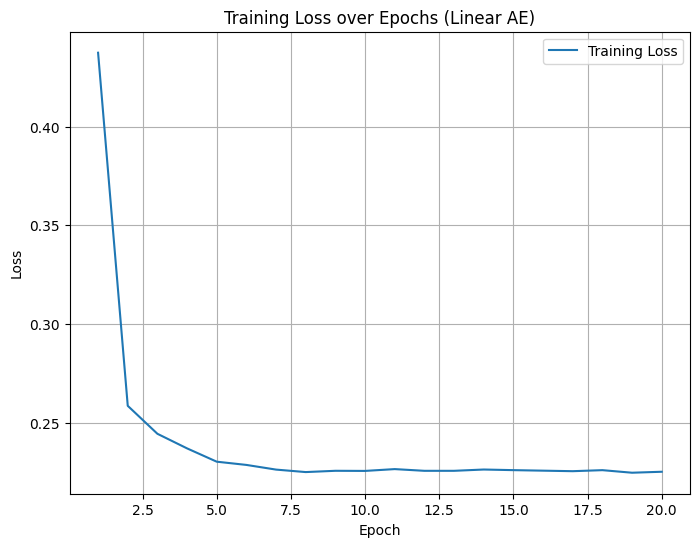

In [12]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Linear Autoencoder
num_epochs = 20
encoded_data_linear = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in trainloader:
        # Flatten images and convert to float tensor
        images = images.view(images.size(0), -1)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, images)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average loss for epoch
    epoch_loss = running_loss / len(trainloader)
    encoded_data_linear.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Plotting the training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), encoded_data_linear, label='Training Loss')
plt.title('Training Loss over Epochs (Linear AE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Project the data using the trained Linear Autoencoder
linear_encoded_data = []
with torch.no_grad():
    for images, labels in trainloader:
        images = flatten_images(images)
        encoded_output = model.encoder(images)
        linear_encoded_data.append(encoded_output.numpy())

linear_encoded_data = np.concatenate(linear_encoded_data, axis=0)


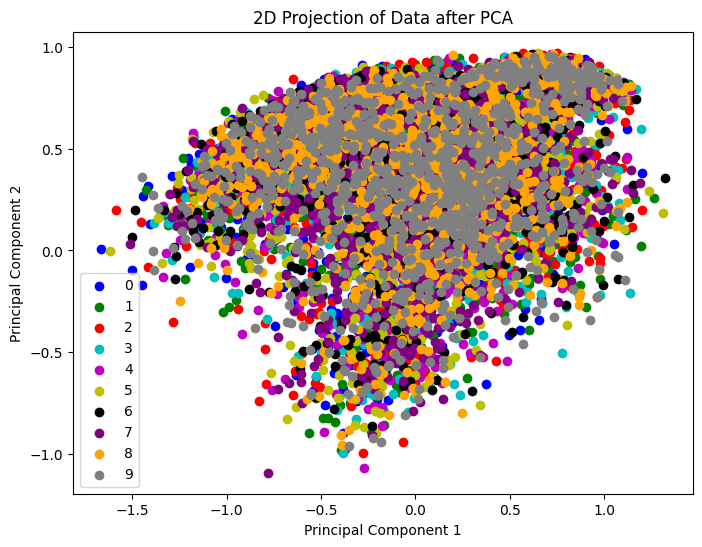

In [13]:
# Plot the projected data
plot_projected_data(linear_encoded_data, np.array([trainset[i][1] for i in train_indices]))

# EX 4 - Discussion (10pts)
1. Write a new plotting function and plot the results side-by-side using subplots.
2. Given the three figures and what we've learned about PCA and AE, answer what are the difference/similarites between the models? How is that indicated in the results?


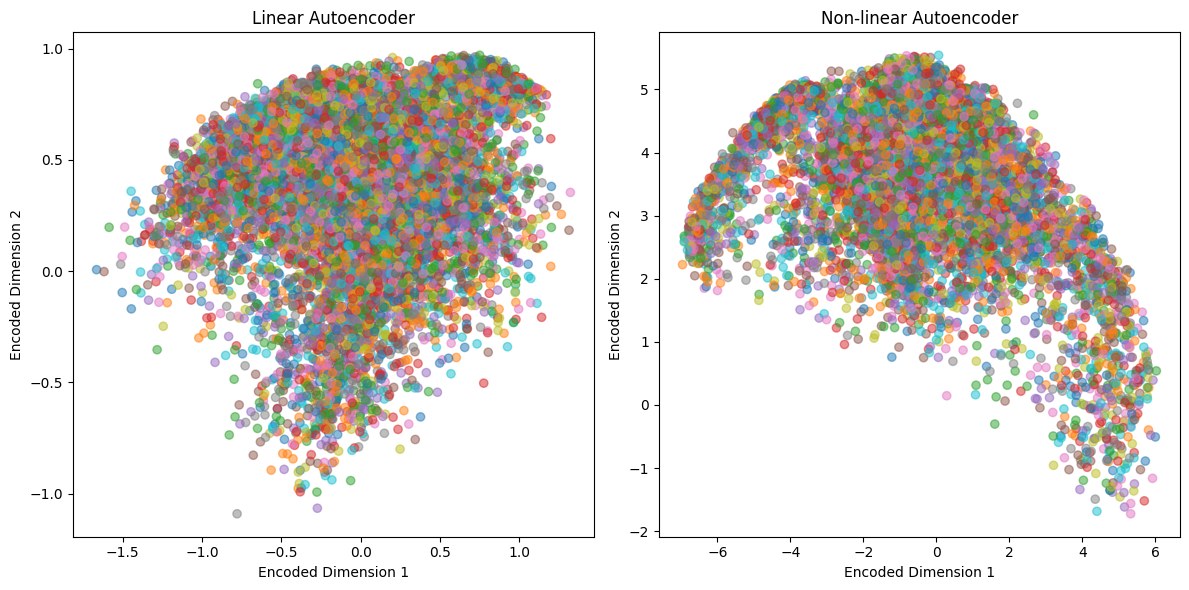

In [14]:
import matplotlib.pyplot as plt

def plot_autoencoder_results(linear_encoded_data, nonlinear_encoded_data, labels):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plot Linear Autoencoder results
    axes[0].scatter(linear_encoded_data[:, 0], linear_encoded_data[:, 1], c=labels, cmap='tab10', alpha=0.5)
    axes[0].set_title('Linear Autoencoder')
    axes[0].set_xlabel('Encoded Dimension 1')
    axes[0].set_ylabel('Encoded Dimension 2')

    # Plot Non-linear Autoencoder results
    axes[1].scatter(nonlinear_encoded_data[:, 0], nonlinear_encoded_data[:, 1], c=labels, cmap='tab10', alpha=0.5)
    axes[1].set_title('Non-linear Autoencoder')
    axes[1].set_xlabel('Encoded Dimension 1')
    axes[1].set_ylabel('Encoded Dimension 2')

    plt.tight_layout()
    plt.show()

# Assuming you have encoded_data and encoded_data_nonlinear from both models
# Plot the projected data
plot_autoencoder_results(linear_encoded_data, encoded_data_nonlinear, np.array([trainset[i][1] for i in train_indices]))


# EX 5 - Denoising AE and Classification (30pts.)
In this section you will implement and train a denosing AE to clean corrupted MNIST images.
You are given a trained MLP model (from DL PS1) with ~94% test set accuracy on the cleaned images. Again, work with only 10k images (a subset of the train set).
Your tasks are as follows:
0. Load the mlp.pth file to your project and initiate the MLP model with the trained weights.
1. Compute the test set accuracy for the clean and corrupted datasets.
2. Implemented and train autoencoder to remove the noise.
3. Visualize the results for 10 images, one for each digit (original image, corrupted image, clean image).
4. Compute the test set accuracy on the cleaned/denoised corrupted test set. Due to the randomness of the gaussian noise, run the procedure 5 times and take the average accuracy.

You may not re-train the classification network or train a new model for classification task.

### Grading for this section:
```python
10pts  # code quality and presentation
20pts = max(cleaned image accuracy + 10, 100)*0.2 #(i.e, accuracy >= 90% will give you a full grade).
```



## Load trained model

In [25]:
# MLP classifier from DL PS1 - DO NOT CHANGE
mlp_clf = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_clf.load_state_dict(torch.load('mlp.pth', map_location=torch.device(device)))


<All keys matched successfully>

## Data and functions

In [26]:
# Noise function - DO NOT CHANGE
def add_gaussian_noise(images, mean=0.0, std=2):
    noise = torch.randn(images.size()) * std + mean
    noisy_images = images + noise
    return noisy_images


# Accuracy - DO NOT CHANGE
def compute_accuracy(model, testloader, denoise_model=None, add_noise=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # False for clean images, True for corrupted/noisy
            if add_noise:
              images = add_gaussian_noise(images)
            # Denoise the image before the classifier
            if denoise_model is not None:
              images = denoise_model(images)
            # reshape to vector form for the MLP
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy



In [27]:
# Compute and print test accuracy for clean and corrupted images
# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)

# Compute and print test accuracy for clean images
clean_accuracy = compute_accuracy(mlp_clf, testloader, denoise_model=None, add_noise=False)
print(f"Test Accuracy on clean images: {clean_accuracy:.2f}%")

# Compute and print test accuracy for corrupted images
corrupted_accuracy = compute_accuracy(mlp_clf, testloader, denoise_model=None, add_noise=True)
print(f"Test Accuracy on corrupted images: {corrupted_accuracy:.2f}%")


Test Accuracy on clean images: 93.98%
Test Accuracy on corrupted images: 59.76%


In [28]:
from torchvision import datasets, transforms  # Import datasets module
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Autoencoder class
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load MNIST train and test datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Sample 10K images from the train set
train_indices = np.random.choice(len(trainset), 10000, replace=False)
train_subset = Subset(trainset, train_indices)

# DataLoader for train and test sets
trainloader = DataLoader(train_subset, batch_size=256, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)

# Initialize the Autoencoder model
autoencoder = DenoisingAutoencoder().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training the Autoencoder
num_epochs = 30

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in trainloader:
        images = images.view(images.size(0), -1).to(device)
        noisy_images = add_gaussian_noise(images.to('cpu')).to(device)

        optimizer.zero_grad()
        outputs = autoencoder(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Save the trained autoencoder model
torch.save(autoencoder.state_dict(), 'autoencoder.pth')

Epoch [1/30], Loss: 0.3373
Epoch [2/30], Loss: 0.2637
Epoch [3/30], Loss: 0.2439
Epoch [4/30], Loss: 0.2305
Epoch [5/30], Loss: 0.2245
Epoch [6/30], Loss: 0.2188
Epoch [7/30], Loss: 0.2160
Epoch [8/30], Loss: 0.2130
Epoch [9/30], Loss: 0.2086
Epoch [10/30], Loss: 0.2055
Epoch [11/30], Loss: 0.2035
Epoch [12/30], Loss: 0.2017
Epoch [13/30], Loss: 0.2006
Epoch [14/30], Loss: 0.1982
Epoch [15/30], Loss: 0.1966
Epoch [16/30], Loss: 0.1966
Epoch [17/30], Loss: 0.1969
Epoch [18/30], Loss: 0.1933
Epoch [19/30], Loss: 0.1933
Epoch [20/30], Loss: 0.1936
Epoch [21/30], Loss: 0.1926
Epoch [22/30], Loss: 0.1920
Epoch [23/30], Loss: 0.1901
Epoch [24/30], Loss: 0.1896
Epoch [25/30], Loss: 0.1902
Epoch [26/30], Loss: 0.1897
Epoch [27/30], Loss: 0.1881
Epoch [28/30], Loss: 0.1877
Epoch [29/30], Loss: 0.1881
Epoch [30/30], Loss: 0.1878


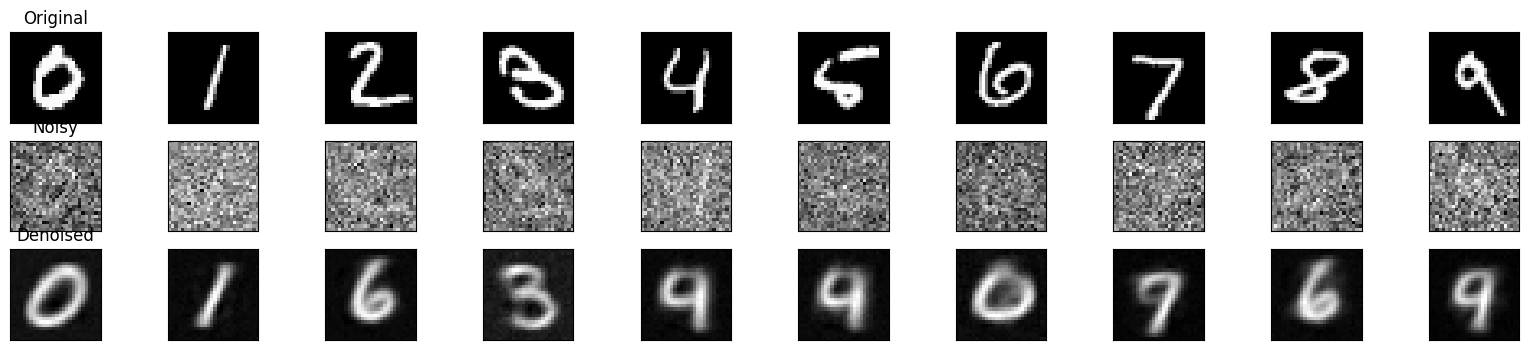

In [29]:
import matplotlib.pyplot as plt

# Function to plot original, noisy, and denoised images
def plot_images(original, noisy, denoised, labels, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original[i].cpu().numpy().reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Original")

        # Noisy images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i].cpu().numpy().reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Noisy")

        # Denoised images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised[i].cpu().numpy().reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Denoised")

    plt.show()

# Get a batch of test data and ensure at least one of each digit is present
digit_images = {}
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    for i in range(len(labels)):
        if labels[i].item() not in digit_images:
            digit_images[labels[i].item()] = images[i]
        if len(digit_images) == 10:  # We need one image for each digit 0-9
            break
    if len(digit_images) == 10:
        break

# Sort the images by digit label
sorted_images = [digit_images[i] for i in range(10)]
sorted_labels = torch.tensor(range(10)).to(device)

# Add noise to sorted images
noisy_images = add_gaussian_noise(torch.stack(sorted_images).to('cpu')).to(device)

# Denoise images
with torch.no_grad():
    denoised_images = autoencoder(noisy_images.view(noisy_images.size(0), -1).to(device))

# Plot images
plot_images(torch.stack(sorted_images), noisy_images, denoised_images, sorted_labels)

In [30]:
# Number of runs for averaging accuracy
num_runs = 5
accuracies = []

# Move mlp_clf and autoencoder to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_clf = mlp_clf.to(device)
autoencoder = autoencoder.to(device)

# Run the procedure 5 times
for run in range(num_runs):
    # Compute and print test accuracy for denoised corrupted images
    autoencoder.eval()  # Ensure autoencoder is in evaluation mode
    mlp_clf.eval()      # Ensure mlp_clf is in evaluation mode

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            # Define add_noise here since it's not defined globally
            add_noise = True  # Change to False if you want clean images

            # Add noise if specified, using add_gaussian_noise function
            if add_noise:
                # Create noisy images on CPU (since you cannot modify add_gaussian_noise)
                noisy_images = add_gaussian_noise(images.cpu()).to(device)
            else:
                noisy_images = images

            # Denoise the image before classification if denoise_model is provided
            if autoencoder is not None:
                denoised_images = autoencoder(noisy_images.view(noisy_images.size(0), -1))
            else:
                denoised_images = noisy_images

            # Reshape images to vector form for MLP
            denoised_images = denoised_images.view(denoised_images.shape[0], -1)

            # Forward pass through the model
            outputs = mlp_clf(denoised_images)
            _, predicted = torch.max(outputs.data, 1)

            # Update accuracy metrics
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f"Run {run+1}: Test Accuracy on denoised corrupted images: {accuracy:.2f}%")

# Compute average accuracy
average_accuracy = sum(accuracies) / num_runs
print(f"\nAverage Test Accuracy on denoised corrupted images over {num_runs} runs: {average_accuracy:.2f}%")

Run 1: Test Accuracy on denoised corrupted images: 57.61%
Run 2: Test Accuracy on denoised corrupted images: 56.95%
Run 3: Test Accuracy on denoised corrupted images: 57.54%
Run 4: Test Accuracy on denoised corrupted images: 58.01%
Run 5: Test Accuracy on denoised corrupted images: 57.82%

Average Test Accuracy on denoised corrupted images over 5 runs: 57.59%
